In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F

import matplotlib.pyplot as plt

## Define model architecture (CNN classifier)

In [2]:
torch.manual_seed(50)

device = "cpu"

def weights_init(m):
	if hasattr(m, "weight"):
		m.weight.data.uniform_(-0.5, 0.5)
	if hasattr(m, "bias"):
		m.bias.data.uniform_(-0.5, 0.5)

n_classes = 10

class LeNet(nn.Module):
	def __init__(self):
		super(LeNet, self).__init__()
		act = nn.Sigmoid
		self.body = nn.Sequential(
			nn.Conv2d(1, 12, kernel_size=5, padding=5//2, stride=2),
			act(),
			nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=2),
			act(),
			nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
			act(),
			nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
			act(),
		)
		self.fc = nn.Sequential(
			nn.Linear(768, n_classes),
		)
		
	def forward(self, x):
		out = self.body(x)
		out = out.view(out.size(0), -1)
		out = self.fc(out)
		return out

In [3]:
def cross_entropy_for_onehot(pred, target):
	return torch.mean(torch.sum(- target * F.log_softmax(pred, dim=-1), 1))

In [4]:
net = LeNet().to(device)
net.apply(weights_init)

criterion = cross_entropy_for_onehot
optimizer = optim.Adam(net.parameters(), lr=0.001)

## Load datset (MNIST)

In [11]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(
	torchvision.datasets.MNIST('/files/', train=True, download=True,
								transform=torchvision.transforms.Compose([
								torchvision.transforms.ToTensor(),
								torchvision.transforms.Normalize(
								(0.1307,), (0.3081,)),
								torchvision.transforms.Resize((32, 32))
								])),
	batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
	torchvision.datasets.MNIST('/files/', train=False, download=True,
								transform=torchvision.transforms.Compose([
								torchvision.transforms.ToTensor(),
								torchvision.transforms.Normalize(
									(0.1307,), (0.3081,)),
								torchvision.transforms.Resize((32, 32))
								])),
	batch_size=batch_size, shuffle=True)

## Train model

In [6]:
for epoch in range(10):  # loop over the dataset multiple times

	running_loss = 0.0
	for batch_idx, (data, target) in enumerate(train_loader):

		labels = torch.zeros((target.shape[0], n_classes), dtype=torch.float)
		for i, l in enumerate(target):
			labels[i][l] = 1.

		# zero the parameter gradients
		optimizer.zero_grad()
		# forward + backward + optimize
		outputs = net(data)
		loss = criterion(outputs, labels)
		loss.backward()
		optimizer.step()

		# print statistics
		running_loss += loss.item()

	print("epoch %d loss: %.3f" % (epoch+1, running_loss / batch_size))

epoch 1 loss: 9.851
epoch 2 loss: 3.062
epoch 3 loss: 2.114
epoch 4 loss: 1.603
epoch 5 loss: 1.320
epoch 6 loss: 1.144
epoch 7 loss: 1.010
epoch 8 loss: 0.918
epoch 9 loss: 0.824
epoch 10 loss: 0.761


### test model

In [12]:
data, label = next(iter(test_loader))
for i in range(len(label)):
	pred = net(torch.unsqueeze(data[i], 0))
	print("expected label %d / model result %d" % (label[i], torch.argmax(pred)))

expected label 0 / model result 0
expected label 7 / model result 7
expected label 2 / model result 2
expected label 7 / model result 7
expected label 5 / model result 5
expected label 3 / model result 3
expected label 4 / model result 4
expected label 0 / model result 0
expected label 2 / model result 1
expected label 0 / model result 0
expected label 6 / model result 6
expected label 7 / model result 7
expected label 1 / model result 1
expected label 9 / model result 9
expected label 0 / model result 0
expected label 2 / model result 2
expected label 8 / model result 8
expected label 7 / model result 7
expected label 3 / model result 3
expected label 6 / model result 6
expected label 3 / model result 3
expected label 2 / model result 2
expected label 9 / model result 9
expected label 2 / model result 2
expected label 4 / model result 4
expected label 0 / model result 0
expected label 9 / model result 9
expected label 9 / model result 9
expected label 7 / model result 7
expected label

## Produce Adversarial images (Deep Dream)

Finished Training
0


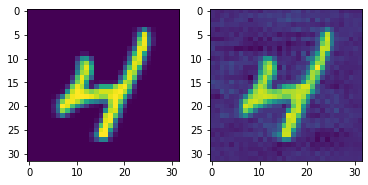

Finished Training
1


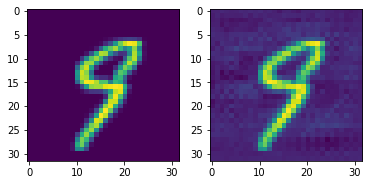

Finished Training
2


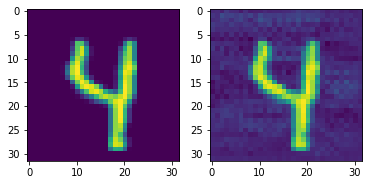

Finished Training
3


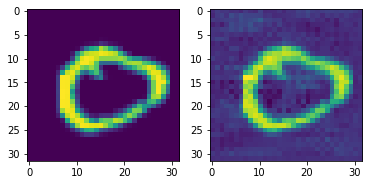

Finished Training
4


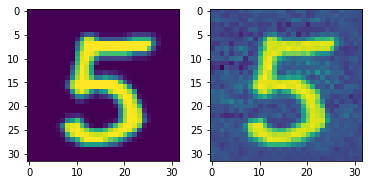

Finished Training
5


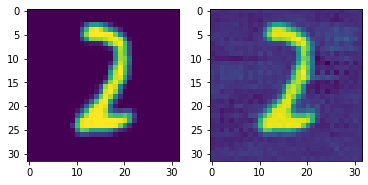

Finished Training
6


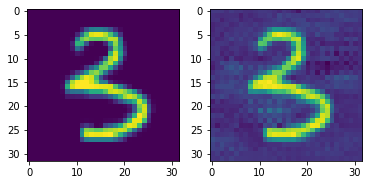

Finished Training
7


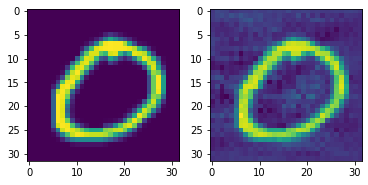

Finished Training
8


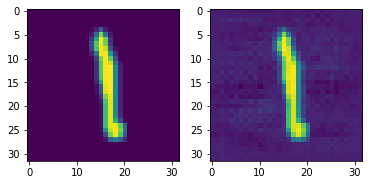

Finished Training
9


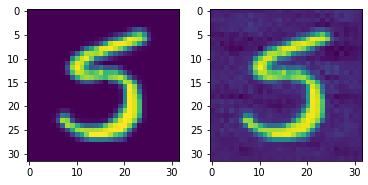

In [15]:
adversarial_images = []

for i in range(n_classes):
	# setup target label
	labels = torch.zeros((1, n_classes), dtype=torch.float)
	labels[0][i] = 1.

	# select 1 image different from target label
	for data, label in test_loader:
		for j in range(len(label)):
			if label[j] != i:
				img = data[j]
				break
			break

	# setup victim image
	inputs = torch.unsqueeze(img, 0).clone().requires_grad_(True) #requires_grad_ will let us update image

	# setup optimizer to backpropagate on image instead of model's weights
	optimizer = optim.SGD([inputs], lr=0.001, momentum=0.9)

	# run until misclassification
	pred = net(inputs)
	while torch.argmax(pred) != i:
		
		running_loss = 0.0
		net.train(False)
		# zero the parameter gradients
		optimizer.zero_grad()
		# forward + backward + optimize
		outputs = net(inputs)
		# compute loss between model prediction and target label
		loss = criterion(outputs, labels)
		loss.backward()
		optimizer.step()

		# print statistics
		running_loss += loss.item()	

		# check model's reaction
		pred = net(inputs)

	print('Finished Training')
	print(i)
	fig, axes = plt.subplots(1, 2)
	axes[0].imshow(img.detach().numpy()[0].reshape((32, 32, 1)))
	axes[1].imshow(inputs.detach().numpy()[0].reshape((32, 32, 1)))
	plt.show()

	adversarial_images.append(inputs)

### Check adversarial effect

In [16]:
for i, adv_img in enumerate(adversarial_images):
	pred = net(adv_img)
	print("expected label %d / model result %d" % (i, torch.argmax(pred)))

expected label 0 / model result 0
expected label 1 / model result 1
expected label 2 / model result 2
expected label 3 / model result 3
expected label 4 / model result 4
expected label 5 / model result 5
expected label 6 / model result 6
expected label 7 / model result 7
expected label 8 / model result 8
expected label 9 / model result 9
